# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [1]:
#pip install pandarallel

In [2]:
#pip install wordcloud

In [3]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [4]:
#pip install tensorflow

In [5]:
#pip install --upgrade tensorflow

In [6]:
#pip install keras

In [7]:
#pip install --upgrade keras

In [8]:
#pip install tensorflow_hub

In [9]:
#pip install --user tensorflow_text

In [10]:
#pip install transformers

In [11]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandarallel import pandarallel

import os
import sys
import time
import random
import re

from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from PIL import Image

In [12]:
# Fichier des tweets à récupérer sur : https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

path = "Flipkart/"
df = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
print(df.shape)
df.head(2)

(1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Je vais garder image plutôt que uniq_id.  
Seuls name, catergory, description dfevraient m'intéresser pour ce clustering.

In [14]:
df = df.rename(columns={"product_name": "name", "product_category_tree": "categ", "description": "desc"})
df = df[["image", "name", "desc", "categ"]]
df.head(2)

,image,name,desc,categ
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."


In [15]:
df.nunique()

image    1050
name     1050
desc     1050
categ     642
dtype: int64

In [16]:
df.categ.isna().sum()

0

In [17]:
df.categ.duplicated(keep=False).sum() + df.categ.nunique()

1146

## Nettoyage du texte

In [18]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['sent_bow'] = df.desc.apply(lambda x : transform_bow_fct(x))
df['sent_bow_lem'] = df.desc.apply(lambda x : transform_bow_lem_fct(x))
df['sent_dl'] = df.desc.apply(lambda x : transform_dl_fct(x))
df.head(2)

,image,name,desc,categ,sent_bow,sent_bow_lem,sent_dl
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...


In [19]:
df.to_csv("Flipkart_df_1.csv")

# Préparation commune des traitements

In [20]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [21]:
#df =  pd.read_csv("Flipkart_df_1.csv")

In [22]:
#l_cat = list(set(df['airline_sentiment']))
#print("catégories : ", l_cat)

catégories :  ['positive', 'negative']

In [23]:
df["cat"] = df.categ.apply(lambda x: re.sub(r'\[\"(.+?) >>.*', r'\1', x))
df.head(2)

,image,name,desc,categ,sent_bow,sent_bow_lem,sent_dl,cat
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,Baby Care


In [24]:
df.cat.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [25]:
df.cat.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat, dtype: int64

In [26]:
l_cat = list(df.cat.unique())

In [27]:
#y_cat_num = [(1-l_cat.index(df.iloc[i]['airline_sentiment'])) for i in range(len(df))]

In [28]:
#from sklearn.preprocessing import LabelEncoder
#enc = LabelEncoder()
#y_cat_num_2 = enc.fit_transform(df.airline_sentiment)
#set(y_cat_num_2 - y_cat_num)

{0}

In [29]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [30]:
#enc = OneHotEncoder(sparse=False)
#y_cat_num = enc.fit_transform(df.cat)
y_cat_num = pd.get_dummies(df.cat)
display(y_cat_num.head(6))
enc = LabelEncoder()
y_cat_num = enc.fit_transform(df.cat)
y_cat_num[:6]

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
5,0,0,0,0,0,0,1


array([4, 0, 0, 4, 4, 6])

In [31]:
from nltk.tokenize import sent_tokenize, word_tokenize

df['len_bow'] = df['sent_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['len_bow'].max())
df['len_dl'] = df['sent_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['len_dl'].max())

max length bow :  379
max length dl :  632


In [32]:
df.iloc[:3,-5:]

,sent_bow_lem,sent_dl,cat,len_bow,len_dl
0,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,Home Furnishing,156,248
1,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,Baby Care,63,84
2,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,Baby Care,158,252


## Fonctions communes

In [33]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [34]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sent_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

In [35]:
cv_fit, ctf_fit, cv_transform, ctf_transform

(CountVectorizer(max_df=0.95, stop_words='english'),
 TfidfVectorizer(max_df=0.95, stop_words='english'),
 <1050x5324 sparse matrix of type '<class 'numpy.int64'>'
 	with 34179 stored elements in Compressed Sparse Row format>,
 <1050x5324 sparse matrix of type '<class 'numpy.float64'>'
 	with 34179 stored elements in Compressed Sparse Row format>)

## Exécution des modèles

In [36]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.3842 time :  6.0

Tf-idf : 
--------
ARI :  0.4282 time :  7.0


## Graphiques

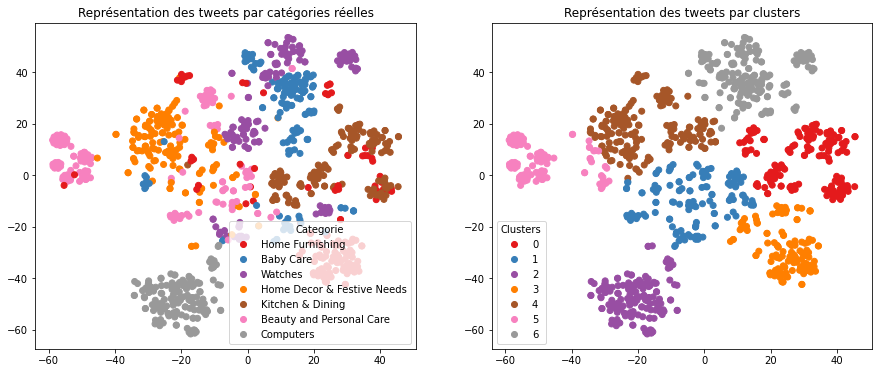

ARI :  0.4282


In [37]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [38]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [39]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['sent_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [40]:
sentences[0][:6], sentences[1][:6], sentences[3][:6], sentences[5][:6]

(['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract'],
 ['specification', 'sathiyas', 'cotton', 'bath', 'towel', 'bath'],
 ['key', 'feature', 'santosh', 'royal', 'fashion', 'cotton'],
 ['maserati', 'time', 'analog', 'watch', 'for', 'boy'])

In [41]:
len(sentences)

1050

In [42]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [43]:
model_vectors, w2v_words[:5]

(<gensim.models.keyedvectors.KeyedVectors at 0x1304785ceb0>,
 ['product', 'only', 'free', 'for', 'buy'])

In [44]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

In [45]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

In [46]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1413900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [47]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 750us/step


(1050, 300)

In [48]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2083 time :  6.0


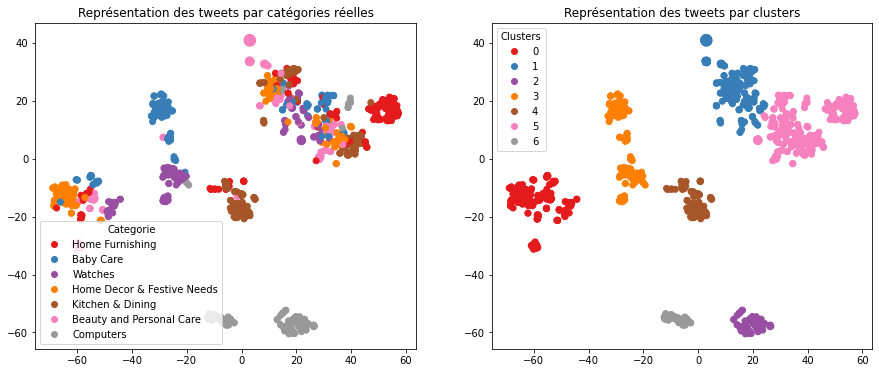

ARI :  0.2083


In [49]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [50]:
l_cat.append("cat_8")
l_cat.append("cat_9")

In [51]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2539 time :  6.0


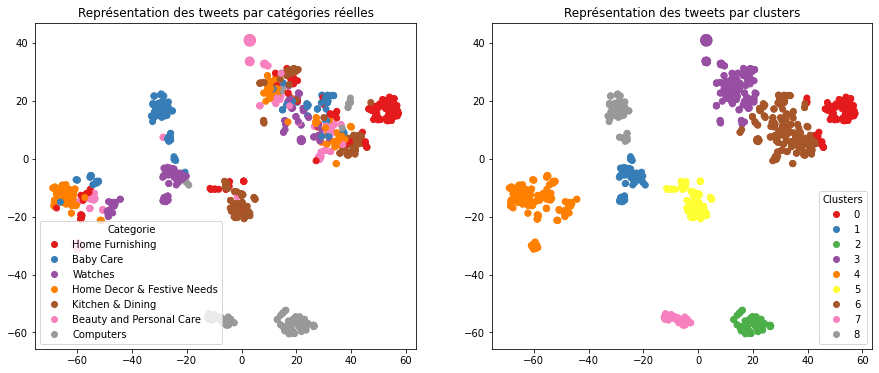

ARI :  0.2539


In [52]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [53]:
l_cat = list(df.cat.unique())
l_cat

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

# BERT

In [54]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
#from transformers import *
from transformers import TFAutoModel, AutoTokenizer

os.environ["TF_KERAS"]='1'

In [55]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  0
True


## Fonctions communes

In [56]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [57]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sent_dl'].to_list()

In [58]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(
    model,
    model_type,
    sentences,
    max_length,
    batch_size,
    mode='HF',
)

1/1 [==============================] - 0s 417ms/step
temps traitement :  58.0


In [59]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.324 time :  6.0


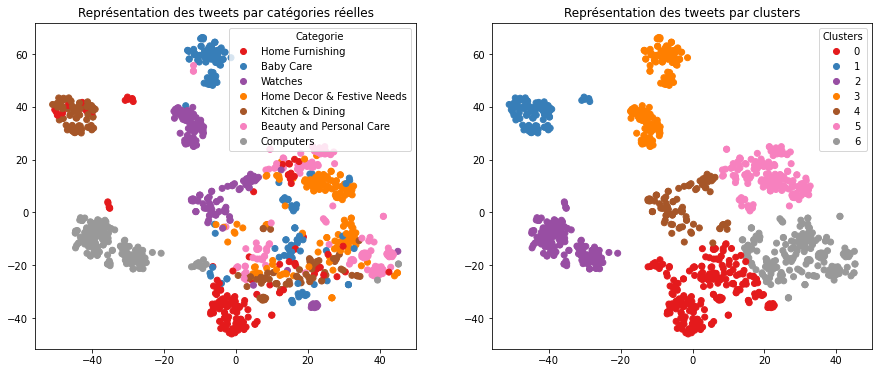

ARI :  0.324


In [60]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [61]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sent_dl'].to_list()

In [62]:
features_bert, last_hidden_states_tot = feature_BERT_fct(
    model,
    model_type,
    sentences,
    max_length,
    batch_size,
    mode='HF'
)

1/1 [==============================] - 0s 455ms/step
temps traitement :  60.0


In [63]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2255 time :  6.0


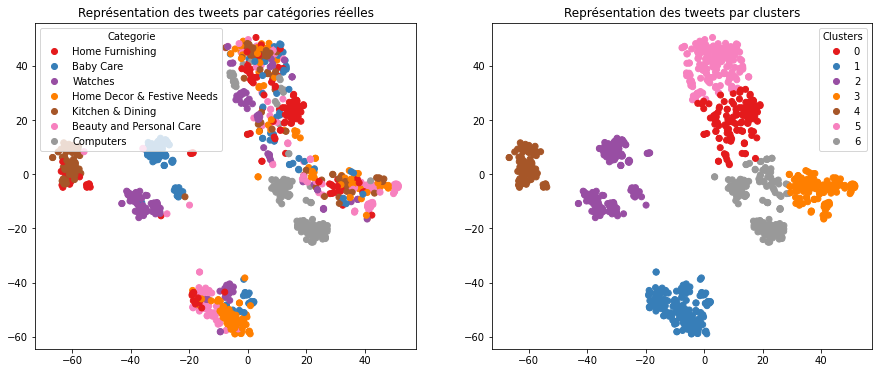

ARI :  0.2255


In [64]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [65]:
#pip install --user tensorflow_text

Note: you may need to restart the kernel to use updated packages.


In [66]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [67]:
sentences = df['sent_dl'].to_list()

In [68]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(
    model,
    model_type,
    sentences,
    max_length,
    batch_size,
    mode='TFhub'
)

temps traitement :  58.0


In [69]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3215 time :  6.0


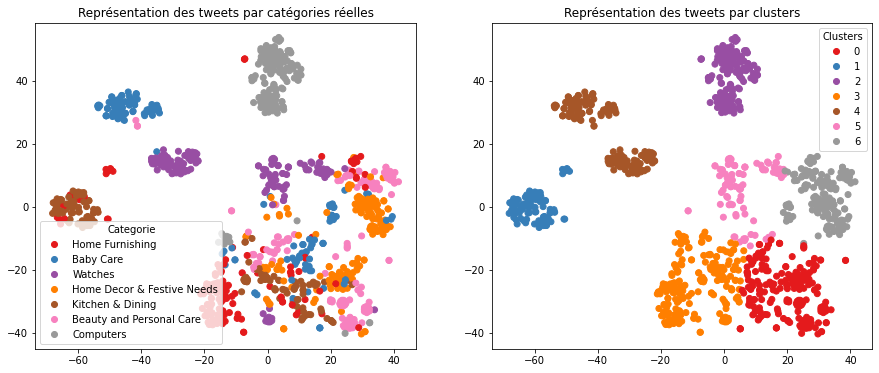

ARI :  0.3215


In [70]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [71]:
%%script echo
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

Couldn't find program: 'echo'


In [72]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  0
True


In [73]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [74]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [75]:
batch_size = 10
sentences = df['sent_dl'].to_list()

In [76]:
features_USE = feature_USE_fct(sentences, batch_size)

In [77]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4454 time :  7.0


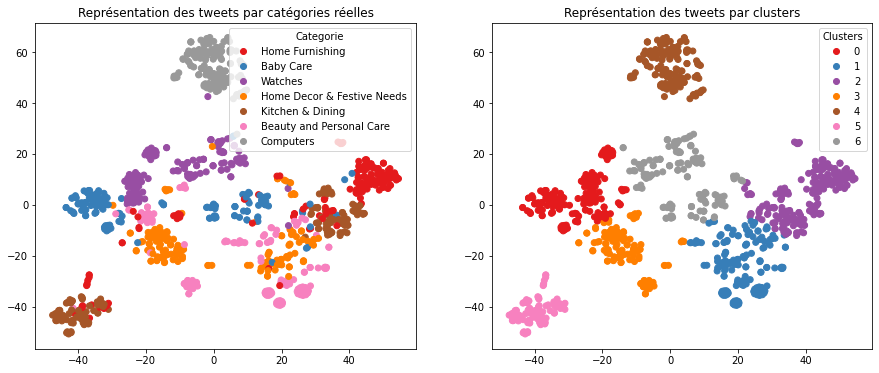

ARI :  0.4454


In [78]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  
>>>>>>> .  

# Image Recognition - Préparation du dataset

## Imports de packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import seaborn as sns

from os import listdir
import re
import time
from IPython.display import clear_output

from sklearn import preprocessing, cluster, metrics, manifold, decomposition
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#from keras.preprocessing.image import img_to_array, load_img
from keras.utils.image_utils import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model

## Import du dataset

In [2]:
path = "Flipkart/"
df = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
df = df.rename(
    columns={"image": "image_name", "product_category_tree": "categ"}
)
df["cat_name"] = df.categ.apply(lambda x: re.sub(r'\[\"(.+?) >>.*', r'\1', x))
df = df[["image_name", "product_name", "cat_name"]]
cat_names = list(df.cat_name.unique())
n_cats = len(cat_names)
display(df.head(2))

,image_name,product_name,cat_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Baby Care


In [3]:
path = "Flipkart/Images/"
photo_names = [file for file in listdir(path)]
n_images = len(photo_names)

## Création des labels des photos à partir du nom des images

In [4]:
def get_cat(photo):
    for cat_name in cat_names:
        if df[df.image_name == photo].cat_name.values[0] == cat_name:
            return cat_name
    return "no_cat_name"

data = pd.DataFrame()
data["image_name"] = photo_names
data["cat_name"] = data["image_name"].apply(lambda x: get_cat(x))
enc = preprocessing.LabelEncoder()
data["label"] = enc.fit_transform(data["cat_name"])
data.head(2)

,image_name,cat_name,label
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining,5


Là ç'aurait été plus rapide de reprendre tout simplement df, mais j'ai voulu
 reprendre exactement le code donné en exemple, donc je viens piocher dans df
 pour fabriquer data.

In [5]:
#data.groupby("label").count()

## Affichage de quelques images par label

Home Furnishing


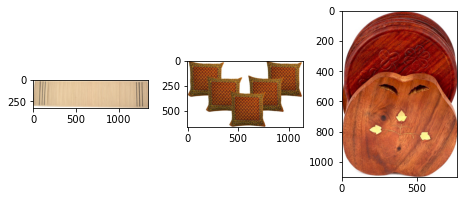

Baby Care


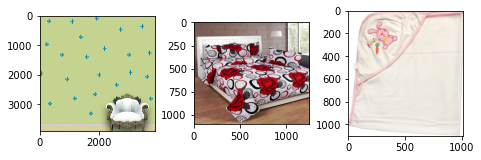

Watches


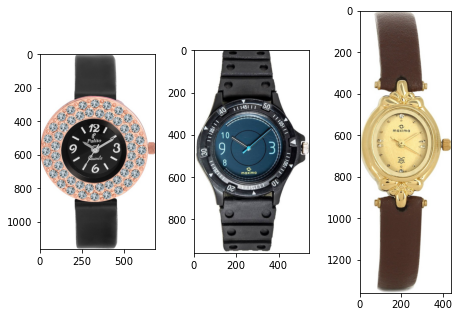

Home Decor & Festive Needs


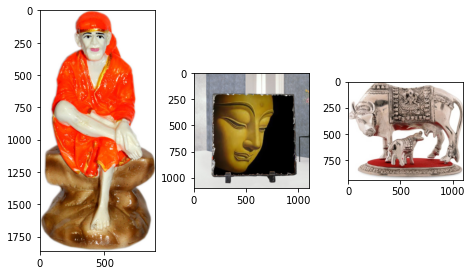

Kitchen & Dining


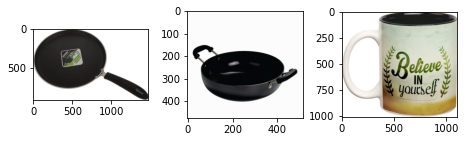

Beauty and Personal Care


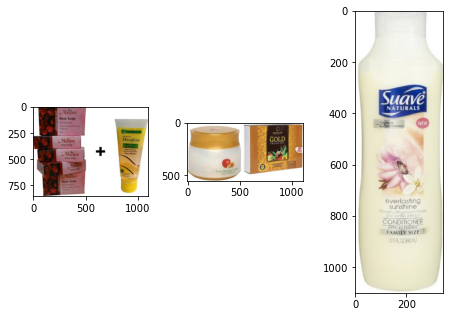

Computers


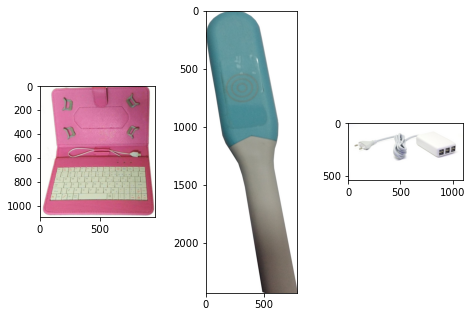

In [6]:
def get_photos(cat):
    photos_of_cat = [i for i in photo_names
                if data.loc[data["image_name"]==i, "cat_name"].item() == cat]
    return photos_of_cat

for cat_name in cat_names:
    print(cat_name)
    for i in range(3):
        plt.subplot(131+i)
        plt.subplots_adjust(
            left=0.01,
            right=0.99,
            bottom=0.01,
            top=0.99,
            wspace=0.34,
            hspace=0.35,
        )
        image_example = imread(path + get_photos(cat_name)[i])
        plt.imshow(image_example)
    plt.show()

# SIFT

## Exemple d'affichage des descripteurs SIFT

In [7]:
#pip install opencv-contrib-python

In [8]:
def extraction(extractor, image):
    image = cv2.equalizeHist(image)
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [9]:
this_image = cv2.imread(path+photo_names[1], 0) # convert to grayscale
sift_uncapped = cv2.xfeatures2d.SIFT_create()

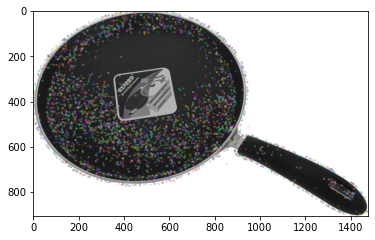

On obtient 4656 keypoints (car uncapped) sur cette image.
Chaque keypoint est représenté par un descriptor comprenant 128 features.
[[ 4.  2.  6. ...  5.  0.  0.]
 [96. 20.  0. ...  9.  2.  0.]
 [55. 16.  0. ...  0.  1.  0.]
 ...
 [12.  0.  0. ...  0.  0.  0.]
 [67. 19.  5. ...  0. 34. 13.]
 [ 0.  5. 27. ...  0.  0.  0.]]


In [10]:
keypoints_of_this_image, descriptors_of_this_image = extraction(
    sift_uncapped,
    this_image,
)
this_image_avec_keypoints = cv2.drawKeypoints(
    this_image,
    keypoints_of_this_image,
    this_image,
)
plt.imshow(this_image_avec_keypoints)
plt.show()
print("On obtient",
      descriptors_of_this_image.shape[0],
      "keypoints (car uncapped) sur cette image.")
print("Chaque keypoint est représenté par un descriptor comprenant",
      descriptors_of_this_image.shape[1],
      "features.")
print(descriptors_of_this_image)

## Création des descripteurs de chaque image

In [11]:
all_descriptors_3D = []
t1 = time.perf_counter()
n_keypoints_max = 500
sift = cv2.xfeatures2d.SIFT_create(n_keypoints_max)

for i, image_name in enumerate(photo_names):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    image = cv2.imread(path+image_name, 0) # convert to grayscale
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = extraction(sift, image)
    all_descriptors_3D.append(descriptors)

all_descriptors_3D = np.asarray(all_descriptors_3D, dtype=object)
all_descriptors_2D = np.concatenate(all_descriptors_3D, axis=0)
duration1 = time.perf_counter()-t1

`all_descriptors_2D` est obtenu par concaténation des éléments de
 `all_descriptors_3D` (les images) sur l'axe des descripteurs donc on se retrouve
 avec une matrice dans laquelle sont données les mêmes `128` features que
 d'habitude mais pour chaque descripteur de chaque image (donc en perdant
 l'information de quels descripteurs appartiennent à quelle image).  
Ça donne donc `128` colonnes et environ `n_images*n_keypoints_max` lignes
 (car sift choisit en fait pour certaines images de les décrire par moins de
 `n_keypoints_max` keypoints).

In [12]:
print("Nombre d'images ("
      + str(n_images)
      + ") fois n_keypoints_max ("
      + str(n_keypoints_max)
      + ") = "
      + str(n_images*n_keypoints_max)
     )
print("Nombre de descripteurs: ", "%33.0f" % all_descriptors_2D.shape[0])
print("Temps de traitement du SIFT descriptor: ",
      "%1.2f" % duration1, "secondes")

Nombre d'images (1050) fois n_keypoints_max (500) = 525000
Nombre de descripteurs:                             517351
Temps de traitement du SIFT descriptor:  276.30 secondes


## Clustering des descripteurs (toutes images confondues)

In [13]:
t1 = time.perf_counter()
k = int(round(np.sqrt(all_descriptors_2D.shape[0]), 0))
print("Nombre de clusters estimés: ", k)
kmeans = cluster.MiniBatchKMeans(n_clusters=k,
                                 init_size=3*k,
                                 batch_size=4096,
                                 random_state=0)
kmeans.fit(all_descriptors_2D)
duration1 = time.perf_counter()-t1
print("temps de traitement kmeans: ", "%1.2f" % duration1, "secondes")

Nombre de clusters estimés:  719
temps de traitement kmeans:  4.58 secondes


## Création des features des images

Features d'une image = Histogramme d'une image = Comptage, pour chaque cluster,
 du nombre de descripteurs appartenant à la fois à l'image et à ce cluster.

In [14]:
def build_histogram(clusterer, image_descriptors, image_num):
    nd = len(image_descriptors)
    res = clusterer.predict(image_descriptors)
    hist = np.zeros(len(clusterer.cluster_centers_))
    if nd==0: print("Problème pour l'histogramme de l'image", image_num)
    for i in res:
        hist[i] += 1.0/nd
    return hist

In [15]:
t1 = time.perf_counter()
all_hists = []
for i, image_descriptors in enumerate(all_descriptors_3D):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    hist = build_histogram(kmeans, image_descriptors, i)
    all_hists.append(hist) #histogram is the feature vector

all_hists = np.asarray(all_hists)
duration1 = time.perf_counter()-t1
print("Temps de création des histogrammes: ", "%1.2f" % duration1, "secondes")

Temps de création des histogrammes:  51.32 secondes


## Réductions de dimension

### Réduction de dimension PCA
La réduction PCA permet:
- de créer des features décorrélées entre elles, et de
 diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé
 (99%).
- une meilleure séparation des données via le T-SNE et une
 réduction du temps de traitement du T-SNE.

In [16]:
print("Dimensions du dataset avant réduction PCA:", all_hists.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(all_hists)
print("Dimensions du dataset après réduction PCA:", feat_pca.shape)

Dimensions du dataset avant réduction PCA: (1050, 719)
Dimensions du dataset après réduction PCA: (1050, 490)


### Réduction de dimension T-SNE pour ne garder que 2 features

In [17]:
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000,
                     init='random',
                     random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:, :2], columns=['tsne1', 'tsne2'])
df_tsne["vraies classes"] = data["cat_name"]
print(df_tsne.shape)

C:\Users\achou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


### Position des images dans le plan tsne avec hue sur les vraies catégories

In [18]:
def tsne_plot(hue):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x="tsne1",
        y="tsne2",
        hue=hue,
        data=df_tsne,
        legend="brief",
        palette=sns.color_palette('tab10', n_colors=n_cats),
        s=50,
        alpha=0.6,
    )
    plt.title(
        "TSNE selon les " + hue,
        fontsize=20,
        pad=10,
        fontweight='bold',
    )
    plt.xlabel(
        'tsne1',
        fontsize=16,
        fontweight='bold',
    )
    plt.ylabel(
        'tsne2',
        fontsize=16,
        fontweight='bold',
    )
    if hue=="vraies classes":
        plt.legend(
            loc='upper right',
            bbox_to_anchor=(1.6, .99),
            ncol=1,
            fancybox=False,
            shadow=True,
            prop={'size': 14},
        )
    elif hue=="clusters":
        plt.legend(
            loc='upper right',
            bbox_to_anchor=(1.16, .99),
            ncol=1,
            fancybox=False,
            shadow=True,
            prop={'size': 14},
        )
    else:
        plt.legend()
    plt.show()

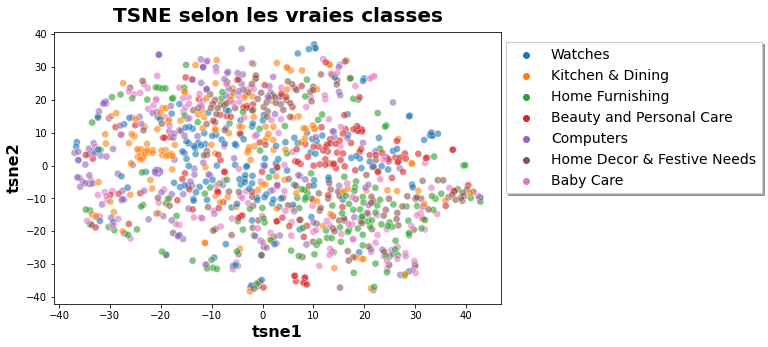

In [19]:
tsne_plot(hue="vraies classes")

## Analyse de similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [20]:
cls = cluster.KMeans(n_clusters=n_cats, random_state=6)
cls.fit(X_tsne)
df_tsne["clusters"] = cls.labels_

### Position des images dans le plan tsne avec hue sur les clusters

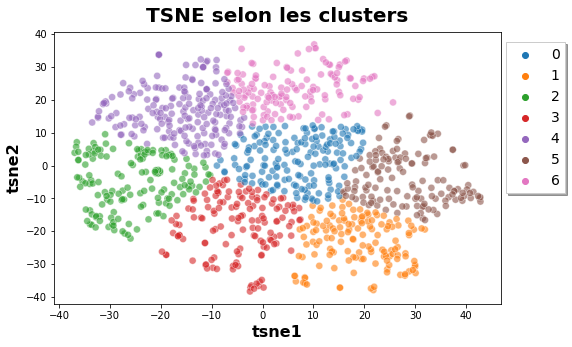

In [21]:
tsne_plot(hue="clusters")

### Calcul ARI de similarité entre catégories vraies/trouvées par le clustering

In [22]:
print("ARI:", metrics.adjusted_rand_score(data["label"], cls.labels_))

ARI: 0.03973321548308855


### Analyse par classes

In [23]:
df_tsne.head(2)

,tsne1,tsne2,vraies classes,clusters
0,28.935438,15.228166,Watches,5
1,-9.042663,32.137066,Kitchen & Dining,4


In [24]:
df_tsne.groupby("clusters").count()["vraies classes"]

clusters
0    165
1    139
2    149
3    142
4    189
5    134
6    132
Name: vraies classes, dtype: int64

In [25]:
metrics.confusion_matrix(data["label"], cls.labels_)

array([[10, 35, 17, 24, 30, 13, 21],
       [52, 12, 11, 16, 15, 29, 15],
       [14,  8, 49, 18, 38,  6, 17],
       [10, 25,  4, 20, 26, 27, 38],
       [13, 46, 13, 24, 18, 26, 10],
       [27,  8, 36, 13, 34, 13, 19],
       [39,  5, 19, 27, 28, 20, 12]], dtype=int64)

In [26]:
corresp = [6, 5, 4, 3, 1, 2, 0]
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    # corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters: ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [27]:
cls_labels_transform = conf_mat_transform(data["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data["label"], cls_labels_transform)
print(metrics.classification_report(data["label"], cls_labels_transform))

Correspondance des clusters:  [6, 5, 4, 3, 1, 2, 0]
              precision    recall  f1-score   support

           0       0.16      0.14      0.15       150
           1       0.08      0.10      0.09       150
           2       0.04      0.04      0.04       150
           3       0.14      0.13      0.14       150
           4       0.09      0.09      0.09       150
           5       0.06      0.05      0.06       150
           6       0.24      0.26      0.25       150

    accuracy                           0.12      1050
   macro avg       0.12      0.12      0.12      1050
weighted avg       0.12      0.12      0.12      1050



<AxesSubplot:>

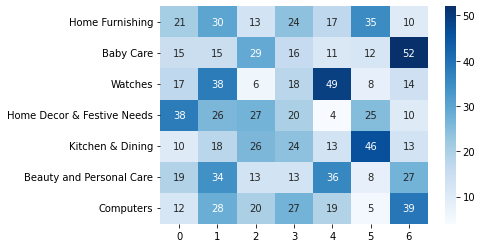

In [28]:
df_cm = pd.DataFrame(
    conf_mat,
    index = [i for i in cat_names],
    columns = [i for i in "0123456"],
)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# ORB

## Exemple d'affichage des descripteurs ORB

In [29]:
def extraction_orb(extractor, image):
    image = cv2.equalizeHist(image)
    keypoints = extractor.detect(image, None)
    keypoints, descriptors = extractor.compute(image, keypoints)
    return keypoints, descriptors

In [30]:
orb_uncapped = cv2.ORB_create()

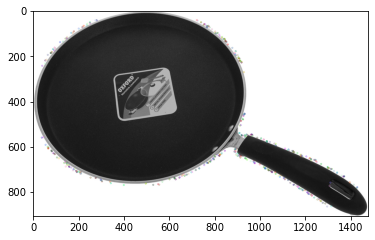

On obtient 500 keypoints (car uncapped) sur cette image.
Chaque keypoint est représenté par un descriptor comprenant 32 features.


In [31]:
keypoints_of_this_image, descriptors_of_this_image = extraction_orb(
    orb_uncapped,
    this_image,
)
this_image_avec_keypoints = cv2.drawKeypoints(
    this_image,
    keypoints_of_this_image,
#    None,
    this_image,
#    color=(0, 255, 0),
#    flags=0,
)
plt.imshow(this_image_avec_keypoints)
plt.show()
print("On obtient",
      descriptors_of_this_image.shape[0],
      "keypoints (car uncapped) sur cette image.")
print("Chaque keypoint est représenté par un descriptor comprenant",
      descriptors_of_this_image.shape[1],
      "features.")

## Création des descripteurs de chaque image

In [32]:
all_descriptors_3D = []
t1 = time.perf_counter()
orb = cv2.ORB_create(n_keypoints_max)

for i, image_name in enumerate(photo_names):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    image = cv2.imread(path+image_name, 0) # convert to grayscale
    keypoints, descriptors = extraction_orb(orb, image)
    all_descriptors_3D.append(descriptors)

all_descriptors_3D = np.asarray(all_descriptors_3D, dtype=object)
all_descriptors_2D = np.concatenate(all_descriptors_3D, axis=0)
duration1 = time.perf_counter()-t1

In [33]:
print("Nombre d'images ("
      + str(n_images)
      + ") fois n_keypoints_max ("
      + str(n_keypoints_max)
      + ") = "
      + str(n_images*n_keypoints_max)
     )
print("Nombre de descripteurs: ", "%33.0f" % all_descriptors_2D.shape[0])
print("Temps de traitement de l'ORB descriptor: ",
      "%1.2f" % duration1, "secondes")

Nombre d'images (1050) fois n_keypoints_max (500) = 525000
Nombre de descripteurs:                             520145
Temps de traitement de l'ORB descriptor:  39.24 secondes


## Clustering des descripteurs (toutes images confondues)

In [34]:
t1 = time.perf_counter()
k = int(round(np.sqrt(all_descriptors_2D.shape[0]), 0))
print("Nombre de clusters estimés: ", k)
kmeans = cluster.MiniBatchKMeans(n_clusters=k,
                                 init_size=3*k,
                                 batch_size=4096,
                                 random_state=0)
kmeans.fit(all_descriptors_2D)
duration1 = time.perf_counter()-t1
print("temps de traitement kmeans: ", "%1.2f" % duration1, "secondes")

Nombre de clusters estimés:  721
temps de traitement kmeans:  2.94 secondes


## Création des features des images

In [35]:
t1 = time.perf_counter()
all_hists = []
for i, image_descriptors in enumerate(all_descriptors_3D):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    hist = build_histogram(kmeans, image_descriptors, i)
    all_hists.append(hist) #histogram is the feature vector

all_hists = np.asarray(all_hists)
duration1 = time.perf_counter()-t1
print("Temps de création des histogrammes: ", "%1.2f" % duration1, "secondes")

Temps de création des histogrammes:  51.10 secondes


## Réductions de dimension

### Réduction de dimension PCA

In [36]:
print("Dimensions du dataset avant réduction PCA:", all_hists.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(all_hists)
print("Dimensions du dataset après réduction PCA:", feat_pca.shape)

Dimensions du dataset avant réduction PCA: (1050, 721)
Dimensions du dataset après réduction PCA: (1050, 576)


### Réduction de dimension T-SNE pour ne garder que 2 features

In [37]:
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000,
                     init='random',
                     random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:, :2], columns=['tsne1', 'tsne2'])
df_tsne["vraies classes"] = data["cat_name"]

C:\Users\achou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### Position des images dans le plan tsne avec hue sur les vraies catégories

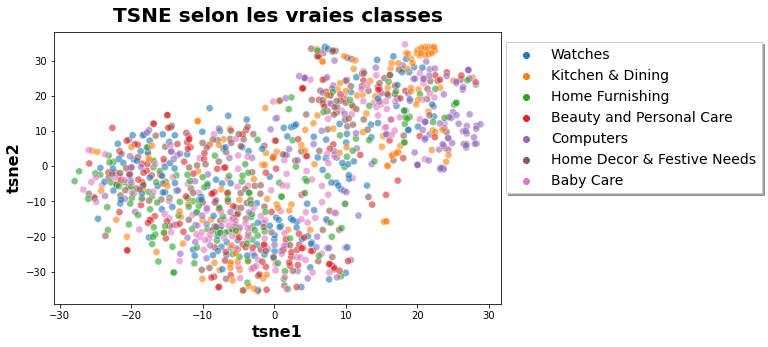

In [38]:
tsne_plot(hue="vraies classes")

## Analyse de similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [39]:
cls = cluster.KMeans(n_clusters=n_cats, random_state=6)
cls.fit(X_tsne)
df_tsne["clusters"] = cls.labels_

### Position des images dans le plan tsne avec hue sur les clusters

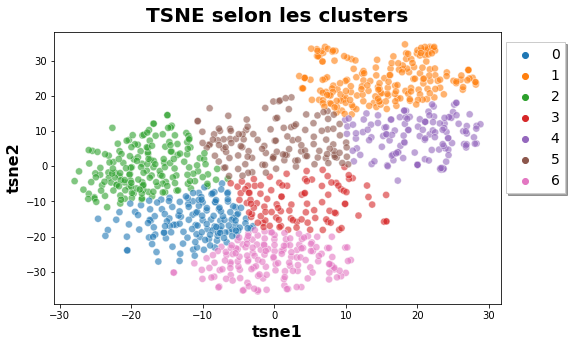

In [40]:
tsne_plot(hue="clusters")

### Calcul ARI de similarité entre catégories vraies/trouvées par le clustering

In [41]:
print("ARI:", metrics.adjusted_rand_score(data["label"], cls.labels_))

ARI: 0.035699192703225


### Analyse par classes

In [42]:
cls_labels_transform = conf_mat_transform(data["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data["label"], cls_labels_transform)
print(metrics.classification_report(data["label"], cls_labels_transform))

Correspondance des clusters:  [6, 5, 4, 3, 1, 2, 0]
              precision    recall  f1-score   support

           0       0.16      0.17      0.17       150
           1       0.05      0.04      0.04       150
           2       0.10      0.08      0.09       150
           3       0.13      0.09      0.10       150
           4       0.17      0.20      0.18       150
           5       0.26      0.35      0.30       150
           6       0.09      0.09      0.09       150

    accuracy                           0.15      1050
   macro avg       0.14      0.15      0.14      1050
weighted avg       0.14      0.15      0.14      1050



<AxesSubplot:>

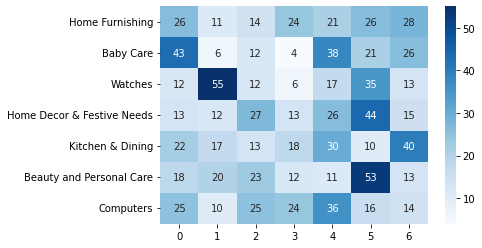

In [43]:
df_cm = pd.DataFrame(
    conf_mat,
    index = [i for i in cat_names],
    columns = [i for i in "0123456"],
)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# CNN

## X/255 impossible

In [44]:
print(photo_names[0])
print(data.image_name[0])
print(imread(path+data.image_name[0]).shape)
print(imread(path+data.image_name[1]).shape)
(imread(path+data.image_name[0])/255)[0][:3]

009099b1f6e1e8f893ec29a7023153c4.jpg
009099b1f6e1e8f893ec29a7023153c4.jpg
(1162, 687, 3)
(904, 1478, 3)


array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [45]:
X = data.image_name[:10].apply(lambda x: imread(path+x)/255)

In [46]:
X[:9]

0    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
1    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
2    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
3    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
4    [[[0.996078431372549, 0.996078431372549, 0.988...
5    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
6    [[[0.9686274509803922, 0.9647058823529412, 0.9...
7    [[[0.9882352941176471, 0.9882352941176471, 0.9...
8    [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
Name: image_name, dtype: object

In [47]:
%%script echo
# Fonctionne pas alors que c'est pareil qu'au'dessus.
X = data.image_name.apply(lambda x: imread(path+x)/255)

Couldn't find program: 'echo'


In [48]:
%%script echo
X = data.image_name.apply(lambda x: imread(path+x))/255

Couldn't find program: 'echo'


In [49]:
%%script echo
# This cell works fine but it's not the correct way to do it anyway.
X = data.image_name.apply(lambda x: imread(path+x)/255.0)

Couldn't find program: 'echo'


In [50]:
%%script echo
# This cell works fine but then i don't manage to divide by 255.
X_temp = data.image_name.apply(lambda x: imread(path+x))
y = data.label

Couldn't find program: 'echo'


In [51]:
%%script echo
#X = X.to_numpy()
X = X_temp/255

Couldn't find program: 'echo'


In [52]:
%%script echo
X = data.image_name.to_numpy()
f = lambda x: imread(path+x)/255
X = f(X)

Couldn't find program: 'echo'


In [53]:
%%script echo
a = 1/255
X = data.image_name.apply(lambda x: a*imread(path+x))

Couldn't find program: 'echo'


In [54]:
#X = X.to_numpy()
#y = y.to_numpy()

## tentons avec une subsample

In [55]:
%%script echo
z = data.sample(frac=.01, weights=None, random_state=1)

Couldn't find program: 'echo'


In [56]:
%%script echo
X = z.image_name

Couldn't find program: 'echo'


In [57]:
%%script echo
X = X.apply(lambda x: imread(path+x)/255)

Couldn't find program: 'echo'


In [58]:
%%script echo
y = z.label

Couldn't find program: 'echo'


Ça permet de créer X ce qui est déjà pas mal, mais ensuite le X n'est pas
 accepté dans le NN. :/

## tentons avec une subsample concaténée à la main

In [59]:
%%script echo
X = np.stack([imread(path+x)/255 for x in data.image_name])

Couldn't find program: 'echo'


In [60]:
%%script echo
data.image_name.to_list()[:10]

Couldn't find program: 'echo'


In [61]:
%%script echo
X = np.stack([imread(path+x)/255 for x in data.image_name.to_list()[:10]])

Couldn't find program: 'echo'


Bah non je peux pas concaténer car c'est un set d'images de dimensions variables.

In [62]:
def imread_and_div(im):
    return imread(path+im)/255

new_width, new_height = 32, 32
def preproc(im):
    im = imread_and_div(im)
    return cv2.resize(im,
                      (new_width, new_height),
                      interpolation=cv2.INTER_NEAREST)

In [63]:
#X = np.stack([preproc(x) for x in data.image_name.to_list()[:10]])
#y = data.label.to_list()[:10]
X = np.stack([preproc(x) for x in data.image_name.to_list()])
y = data.label

C:\Users\achou\anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## suite

In [64]:
train_images, test_images, train_labels, test_labels = train_test_split(
    X,
    y,
    test_size=.2,
)

In [65]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((840, 32, 32, 3), (210, 32, 32, 3), (840,), (210,))

In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

In [68]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [70]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
27/27 [==============================] - 1s 22ms/step - loss: 2.0555 - accuracy: 0.1417 - val_loss: 1.9208 - val_accuracy: 0.2238
Epoch 2/10
27/27 [==============================] - 0s 13ms/step - loss: 1.9154 - accuracy: 0.2143 - val_loss: 1.8375 - val_accuracy: 0.2190
Epoch 3/10
27/27 [==============================] - 0s 14ms/step - loss: 1.7488 - accuracy: 0.3143 - val_loss: 1.7440 - val_accuracy: 0.3476
Epoch 4/10
27/27 [==============================] - 0s 13ms/step - loss: 1.6300 - accuracy: 0.3952 - val_loss: 1.6003 - val_accuracy: 0.3905
Epoch 5/10
27/27 [==============================] - 0s 13ms/step - loss: 1.5009 - accuracy: 0.4333 - val_loss: 1.4883 - val_accuracy: 0.5000
Epoch 6/10
27/27 [==============================] - 0s 14ms/step - loss: 1.4063 - accuracy: 0.4738 - val_loss: 1.4247 - val_accuracy: 0.5286
Epoch 7/10
27/27 [==============================] - 0s 14ms/step - loss: 1.2970 - accuracy: 0.5179 - val_loss: 1.4220 - val_accuracy: 0.5143
Epoch 8/10
27

7/7 - 0s - loss: 1.3266 - accuracy: 0.5381 - 45ms/epoch - 6ms/step


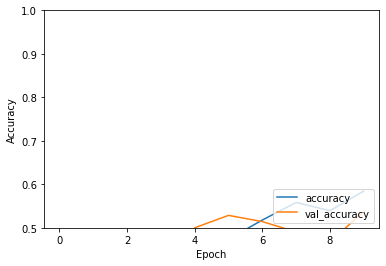

In [71]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [72]:
print(test_acc)

0.538095235824585


# Transfer Learning

VGG16 mais possible aussi:
- VGG19
- GoogLeNet (e.g. InceptionV3)
- Residual Network (e.g. ResNet50)

## VGG

### Direct classification

In [73]:
def imread_sans_div(im):
    return imread(path+im)
new_width, new_height, n_rgb = 224, 224, 3
def preproc_4(im):
    im = imread_sans_div(im)
    return im.reshape((1, new_width, new_height, n_rgb))

In [74]:
shp_0 = (imread(path+data.image_name.to_list()[0])).shape
shp_0

(1162, 687, 3)

In [75]:
%%script echo
imread(path+data.image_name.to_list()[0]).reshape((1, new_width, new_height, n_rgb))

Couldn't find program: 'echo'


```
----------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Input In [65], in <cell line: 1>()
----> 1 imread(path+data.image_name.to_list()[0]).reshape((1, new_width, new_height, n_rgb))

ValueError: cannot reshape array of size 2394882 into shape (1,224,224,3)
```

Pourtant on vient à l'instant de voir que
`imread(path+data.image_name.to_list()[0])`
est un array de shape `(1162, 687, 3)` et pas un array 1D de `2394882` de long.

In [76]:
shp_0[0]*shp_0[1]*shp_0[2] - 2394882

0

In [77]:
%%script echo
#images = data.image_name.apply(lambda x: imread(path+x))
images = np.stack([preproc_4(x) for x in data.image_name.to_list()])
prepared_images = preprocess_input(images)

Couldn't find program: 'echo'


In [78]:
%%script echo
new_input = Input(shape=(224, 224, 3))
model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=new_input,
    pooling="max",
    classes=n_cats,
)
model.summary()

Couldn't find program: 'echo'


In [79]:
%%script echo
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]

Couldn't find program: 'echo'


### Transfer of the features-extractor only

In [80]:
new_width, new_height = 224, 224
def my_preproc(img_name):
    img_name = path + img_name
    image = load_img(img_name, target_size=(new_width, new_height))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

In [81]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [82]:
def pred(img_name):
    image = my_preproc(img_name)
    features = model.predict(image)
    return features

In [83]:
all_features_2D = []
t1 = time.perf_counter()

for i, image_name in enumerate(photo_names):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    all_features_2D.append(pred(image_name))

all_features_2D = np.asarray(all_features_2D, dtype=object)
all_features_1D = np.concatenate(all_features_2D, axis=0)
duration1 = time.perf_counter()-t1

1/1 [==============================] - 0s 111ms/step


### Réductions de dimension

#### Réduction de dimension PCA

In [84]:
print("Dimensions du dataset avant réduction PCA:", all_features_1D.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(all_features_1D)
print("Dimensions du dataset après réduction PCA:", feat_pca.shape)

Dimensions du dataset avant réduction PCA: (1050, 4096)
Dimensions du dataset après réduction PCA: (1050, 803)


#### Réduction de dimension T-SNE pour ne garder que 2 features

In [85]:
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000,
                     init='random',
                     random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:, :2], columns=['tsne1', 'tsne2'])
df_tsne["vraies classes"] = data["cat_name"]

C:\Users\achou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Position des images dans le plan tsne avec hue sur les vraies catégories

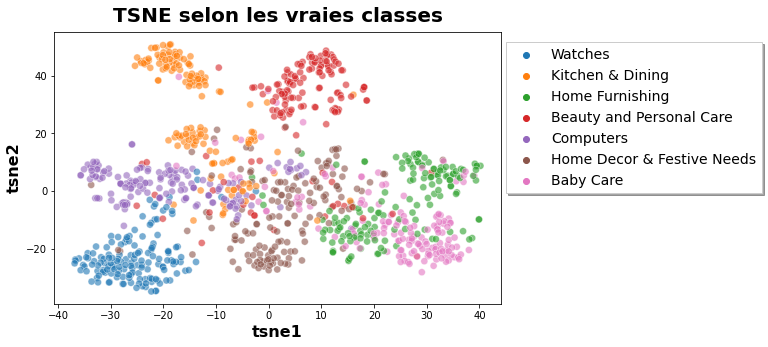

In [86]:
tsne_plot(hue="vraies classes")

### Analyse de similarité entre catégories et clusters

####  Création de clusters à partir du T-SNE

In [87]:
cls = cluster.KMeans(n_clusters=n_cats, random_state=6)
cls.fit(X_tsne)
df_tsne["clusters"] = cls.labels_

#### Position des images dans le plan tsne avec hue sur les clusters

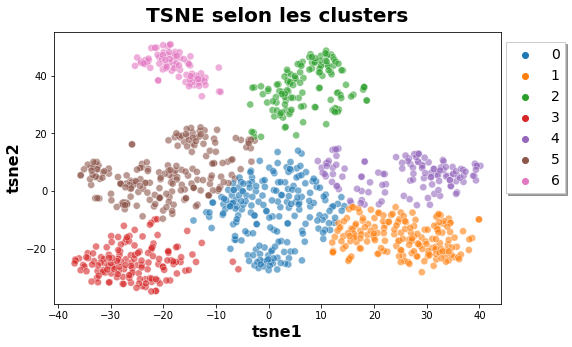

In [88]:
tsne_plot(hue="clusters")

#### Calcul ARI de similarité entre catégories vraies/trouvées par le clustering

In [89]:
print("ARI:", metrics.adjusted_rand_score(data["label"], cls.labels_))

ARI: 0.4729190886569351


#### Analyse par classes

In [90]:
cls_labels_transform = conf_mat_transform(data["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data["label"], cls_labels_transform)
print(metrics.classification_report(data["label"], cls_labels_transform))

Correspondance des clusters:  [6, 5, 4, 3, 1, 2, 0]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       150
           1       0.02      0.02      0.02       150
           2       0.59      0.77      0.67       150
           3       0.04      0.04      0.04       150
           4       0.00      0.00      0.00       150
           5       0.00      0.00      0.00       150
           6       0.01      0.01      0.01       150

    accuracy                           0.12      1050
   macro avg       0.10      0.12      0.11      1050
weighted avg       0.10      0.12      0.11      1050



<AxesSubplot:>

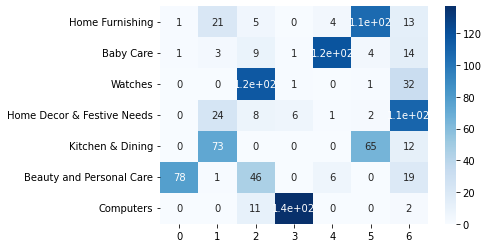

In [91]:
df_cm = pd.DataFrame(
    conf_mat,
    index = [i for i in cat_names],
    columns = [i for i in "0123456"],
)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## ResNet

### Transfer of the features-extractor only

In [103]:
from keras.applications.resnet import ResNet50
model = ResNet50()
#model.summary()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

102967424/102967424 [==============================] - 14s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [106]:
all_features_2D = []
t1 = time.perf_counter()

for i, image_name in enumerate(photo_names):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    all_features_2D.append(pred(image_name))

all_features_2D = np.asarray(all_features_2D, dtype=object)
all_features_1D = np.concatenate(all_features_2D, axis=0)
duration1 = time.perf_counter()-t1

1/1 [==============================] - 1s 550ms/step


### Réductions de dimension

#### Réduction de dimension PCA

In [107]:
print("Dimensions du dataset avant réduction PCA:", all_features_1D.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(all_features_1D)
print("Dimensions du dataset après réduction PCA:", feat_pca.shape)

Dimensions du dataset avant réduction PCA: (1050, 2048)
Dimensions du dataset après réduction PCA: (1050, 722)


#### Réduction de dimension T-SNE pour ne garder que 2 features

In [108]:
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000,
                     init='random',
                     random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:, :2], columns=['tsne1', 'tsne2'])
df_tsne["vraies classes"] = data["cat_name"]

C:\Users\achou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Position des images dans le plan tsne avec hue sur les vraies catégories

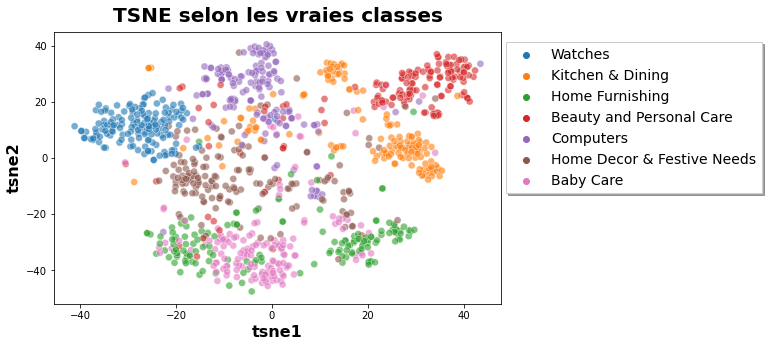

In [109]:
tsne_plot(hue="vraies classes")

### Analyse de similarité entre catégories et clusters

####  Création de clusters à partir du T-SNE

In [110]:
cls = cluster.KMeans(n_clusters=n_cats, random_state=6)
cls.fit(X_tsne)
df_tsne["clusters"] = cls.labels_

#### Position des images dans le plan tsne avec hue sur les clusters

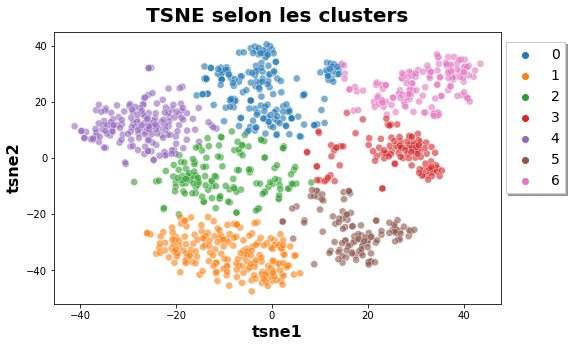

In [111]:
tsne_plot(hue="clusters")

#### Calcul ARI de similarité entre catégories vraies/trouvées par le clustering

In [112]:
print("ARI:", metrics.adjusted_rand_score(data["label"], cls.labels_))

ARI: 0.514320623221389


#### Analyse par classes

In [113]:
cls_labels_transform = conf_mat_transform(data["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data["label"], cls_labels_transform)
print(metrics.classification_report(data["label"], cls_labels_transform))

Correspondance des clusters:  [6, 5, 4, 3, 1, 2, 0]
              precision    recall  f1-score   support

           0       0.03      0.03      0.03       150
           1       0.03      0.03      0.03       150
           2       0.06      0.05      0.05       150
           3       0.11      0.08      0.09       150
           4       0.05      0.05      0.05       150
           5       0.00      0.00      0.00       150
           6       0.01      0.01      0.01       150

    accuracy                           0.03      1050
   macro avg       0.04      0.03      0.04      1050
weighted avg       0.04      0.03      0.04      1050



<AxesSubplot:>

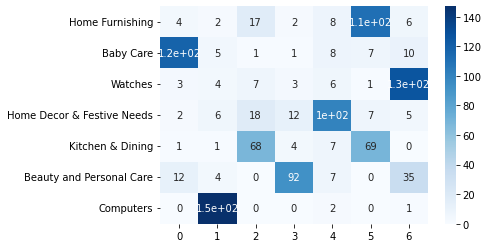

In [114]:
df_cm = pd.DataFrame(
    conf_mat,
    index = [i for i in cat_names],
    columns = [i for i in "0123456"],
)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Inception

### Transfer of the features-extractor only

In [115]:
new_width, new_height = 299, 299
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3()
#model.summary()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [116]:
all_features_2D = []
t1 = time.perf_counter()

for i, image_name in enumerate(photo_names):
    clear_output()
    if i%100 == 0: print(i, "images traitées sur", n_images)
    all_features_2D.append(pred(image_name))

all_features_2D = np.asarray(all_features_2D, dtype=object)
all_features_1D = np.concatenate(all_features_2D, axis=0)
duration1 = time.perf_counter()-t1

1/1 [==============================] - 1s 1s/step


### Réductions de dimension

#### Réduction de dimension PCA

In [117]:
print("Dimensions du dataset avant réduction PCA:", all_features_1D.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(all_features_1D)
print("Dimensions du dataset après réduction PCA:", feat_pca.shape)

Dimensions du dataset avant réduction PCA: (1050, 2048)
Dimensions du dataset après réduction PCA: (1050, 248)


#### Réduction de dimension T-SNE pour ne garder que 2 features

In [118]:
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=2000,
                     init='random',
                     random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:, :2], columns=['tsne1', 'tsne2'])
df_tsne["vraies classes"] = data["cat_name"]

C:\Users\achou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Position des images dans le plan tsne avec hue sur les vraies catégories

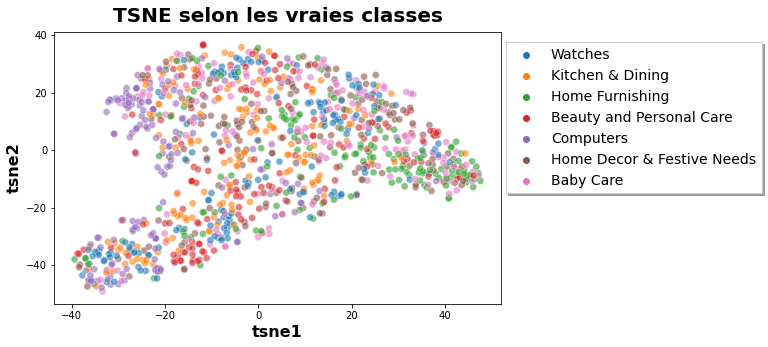

In [119]:
tsne_plot(hue="vraies classes")

### Analyse de similarité entre catégories et clusters

####  Création de clusters à partir du T-SNE

In [120]:
cls = cluster.KMeans(n_clusters=n_cats, random_state=6)
cls.fit(X_tsne)
df_tsne["clusters"] = cls.labels_

#### Position des images dans le plan tsne avec hue sur les clusters

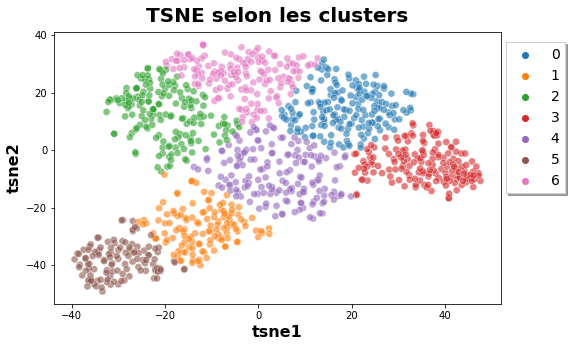

In [121]:
tsne_plot(hue="clusters")

#### Calcul ARI de similarité entre catégories vraies/trouvées par le clustering

In [122]:
print("ARI:", metrics.adjusted_rand_score(data["label"], cls.labels_))

ARI: 0.06903908053271798


#### Analyse par classes

In [123]:
cls_labels_transform = conf_mat_transform(data["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data["label"], cls_labels_transform)
print(metrics.classification_report(data["label"], cls_labels_transform))

Correspondance des clusters:  [6, 5, 4, 3, 1, 2, 0]
              precision    recall  f1-score   support

           0       0.21      0.21      0.21       150
           1       0.17      0.18      0.17       150
           2       0.34      0.27      0.30       150
           3       0.17      0.18      0.17       150
           4       0.05      0.05      0.05       150
           5       0.19      0.16      0.17       150
           6       0.22      0.25      0.23       150

    accuracy                           0.19      1050
   macro avg       0.19      0.19      0.19      1050
weighted avg       0.19      0.19      0.19      1050



<AxesSubplot:>

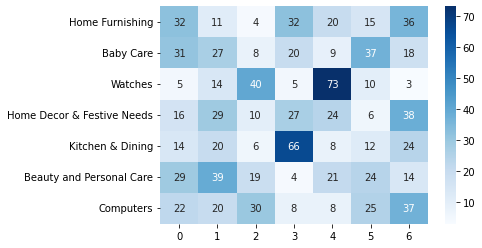

In [124]:
df_cm = pd.DataFrame(
    conf_mat,
    index = [i for i in cat_names],
    columns = [i for i in "0123456"],
)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")